In [53]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM.MinimalModelSemisymbolic

using Base.Threads
using JLD2
using DataFrames, FreqTables, AlgebraOfGraphics, NamedArrays, StatsBase

In [216]:
using GLMakie
using CairoMakie
CairoMakie.activate!()
GLMakie.activate!(; px_per_unit=2.)
# display(GLMakie.Screen(), f.figure)
ENV["COLUMNS"] = 280

280

# Loading pscan data

In [207]:
data = jldopen("../cluster_env/runs/mmsa_pscan5/out.jld2");
params_mlKcd = [data[x] for x in ["m", "l", "K", "c", "d"]];
params_Ds = [data[x] for x in ["DN", "DG", "DR"]];
df = data["df"];

In [11]:
function get_random_row(df)
    df[rand(1:nrow(df)),:]
end
function df_row_to_mmp(dfrow)
    MinimalModelParamsSpace(
        dfrow.m, dfrow.l, dfrow.K, dfrow.c, dfrow.d,
        dfrow.DN, dfrow.DG, dfrow.DR
    )
end

df_row_to_mmp (generic function with 1 method)

# Basics and plots

In [208]:
@show nrow(df)
describe(df)

nrow(df) = 35754802


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,0.599407,0.0078125,0.13313,4.0,0,Float64
2,l,0.684701,0.1,0.8,1.0,0,Float64
3,K,7.9777,0.0625,3.31101,32.0,0,Float64
4,c,3.92717,0.0078125,1.0,16.0,0,Float64
5,d,2.2169,0.0078125,0.25,16.0,0,Float64
6,DN,1.46177,1.0e-7,7.8476e-6,23357.2,0,Float64
7,DG,26321.5,4.28133e-7,5455.59,100000.0,0,Float64
8,DR,804.58,1.0e-7,0.00263665,100000.0,0,Float64
9,numss,1.00087,1,1.0,2,0,Int64


## Checks

### Multiple steady states?

In [220]:
mssdf = df[df.numss .!= 1,:];
nrow(mssdf)

31260

### Testing scanning k stability analysis

In [ ]:
N = 1000
ks = LinRange(0., 1000., 100000)
for _ in 1:N
    dfrow = get_random_row(df)
    mmpf = df_row_to_mmp(dfrow)
    xx = analyze_single_mmps_kscan(mmpf, ks)
    if xx[2] != dfrow.nummodes
        @show xx# dfrow.numss dfrow.nummodes
        @show analyze_single_mmps_Kpoly(mmpf)
    end
end

## Exploratory plots

### Correlations

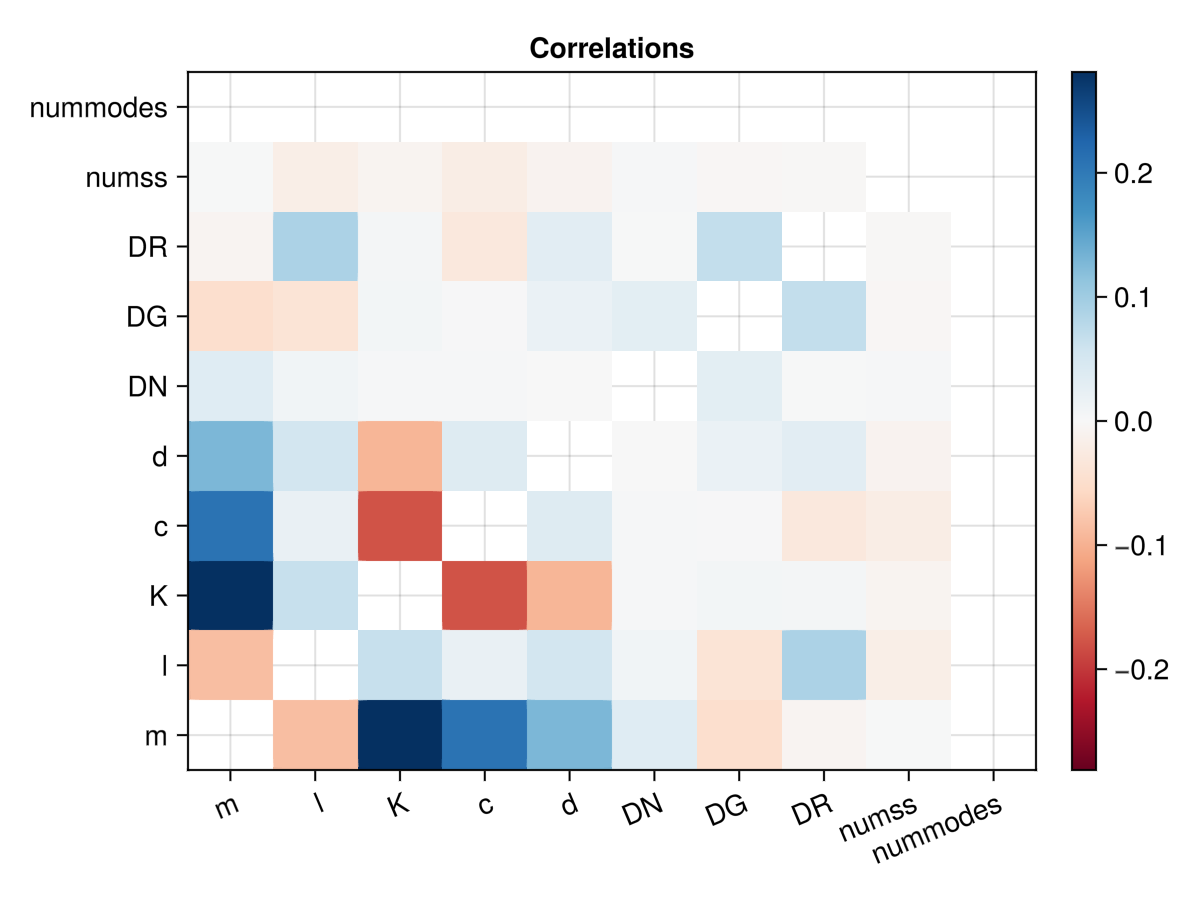

In [217]:
fap = plot_df_correlations(df)
# display(GLMakie.Screen(), fap.figure)
fap

### One dim freqs

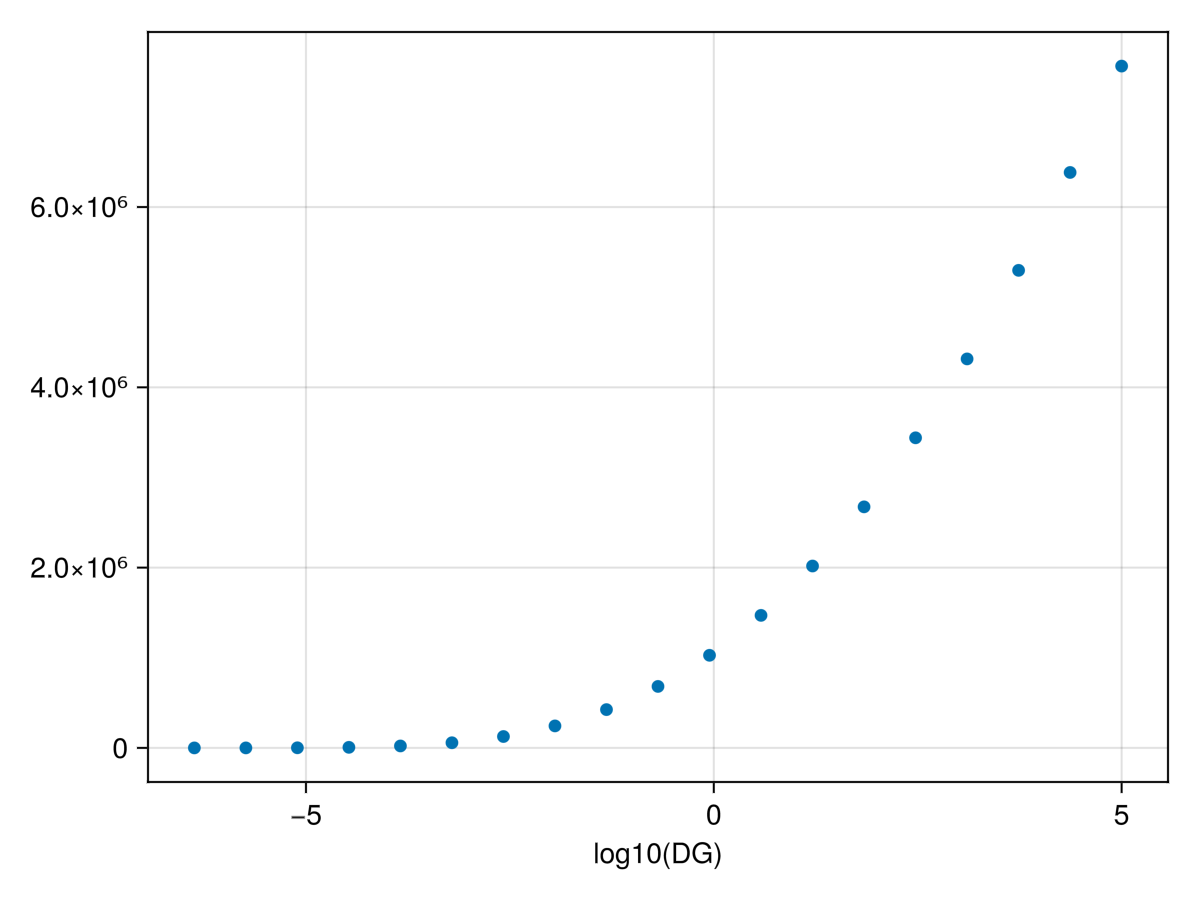

In [218]:
xx = freqtable(df, :DG)
plot_namedvector_numeric(xx; logx=true)

### Two dim freqs

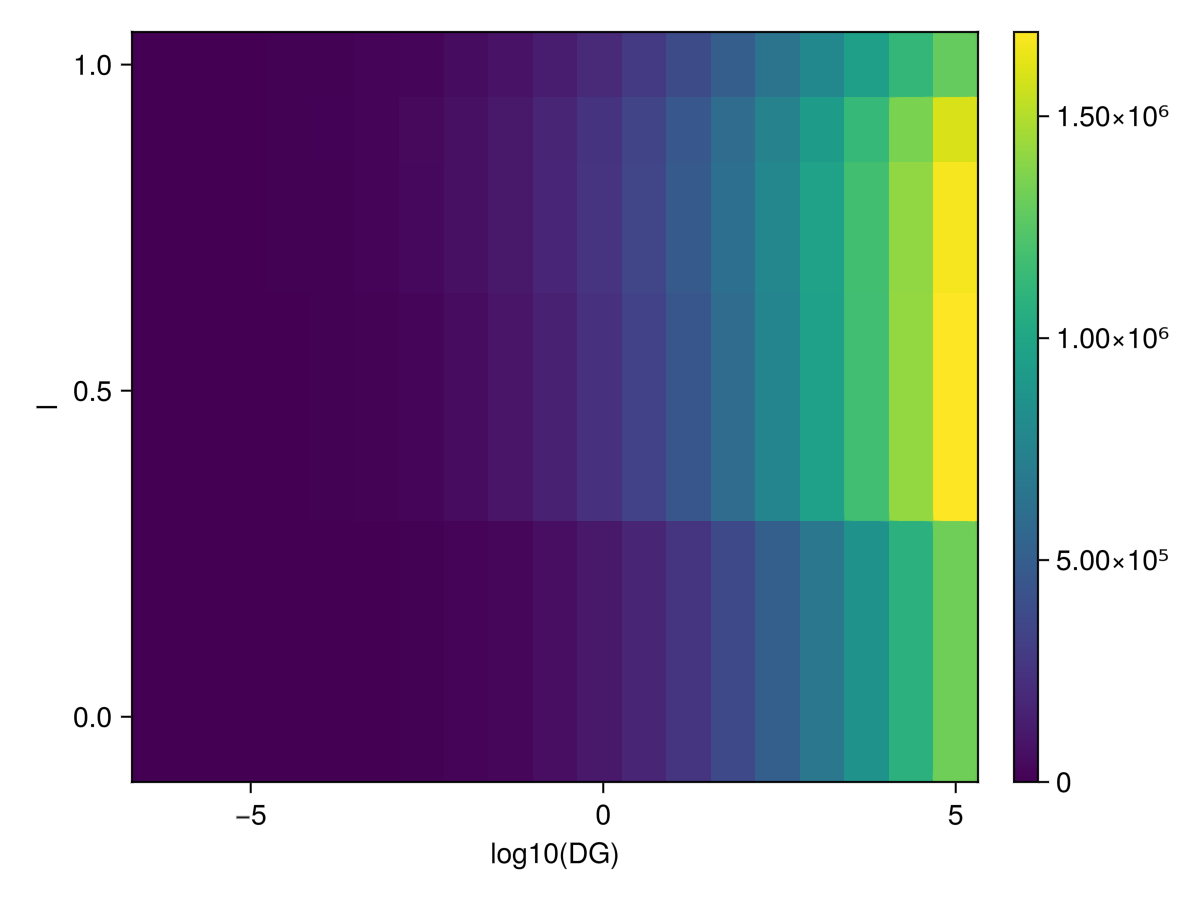

In [219]:
xx = freqtable(df, :DG, :l);
plot_namedmatrix_numeric(xx; logx=true)

# Additional numerics for a single system

In [267]:
mmpf = df_row_to_mmp(get_random_row(mssdf));

In [268]:
# mmpf = MinimalModelParamsSpace(0.1, 0., 10., 0.01, 0.01, 1e-5, 0.01584893192461114, 0.00039810717055349735);
# mmpf = MinimalModelParamsSpace(fi_to_fparams(fi_to_run)...)
mmicrm_params = mmp_to_mmicrm(mmpf);
mmpf

MinimalModelParamsSpace{Float64}(0.0078125, 0.5, 0.0625, 0.25000000000000006, 0.49999999999999983, 7.847599703514624e-6, 0.8858667904100832, 3.359818286283781e-5)

In [276]:
xx = da_get_diff_lengthscales_simple(mmicrm_params, get_Ds(mmpf), [1., 1., 1.]; include_infs=false)
(2*pi) ./ xx

(2242.907934543343, 0.5900525247776578)

In [270]:
xx = analyze_single_mmps_Kpoly(mmpf; include_extinct=false)
println((xx[1], xx[2]))
print("sss: ")
show(xx[3])
println()
print("kroots fe ss: ")
show(xx[4])
println()
print("nummodes fe ss fe segment: ")
show(xx[5])

(1, 1)
sss: [[2.0000000000000013, 0.04166666666666666, 0.0052083333333333365]]
kroots fe ss: [[1.314908733981396, 12.729578438068602]]
nummodes fe ss fe segment: [[0, 1, 0]]

In [271]:
# choose a ss for lisntab etc.
nssol = xx[3][1]

3-element Vector{Float64}:
 2.0000000000000013
 0.04166666666666666
 0.0052083333333333365

In [277]:
xx = analyze_single_mmps_kscan(mmpf, LinRange(0., 100., 1000))

(1, 1, [[2.0000000000000013, 0.04166666666666666, 0.0052083333333333365]], Bool[0])

## Numerics

#### No space solver

3-element Vector{Float64}:
 0.016358948231046534
 0.04953464527684986
 0.0010275747912307633

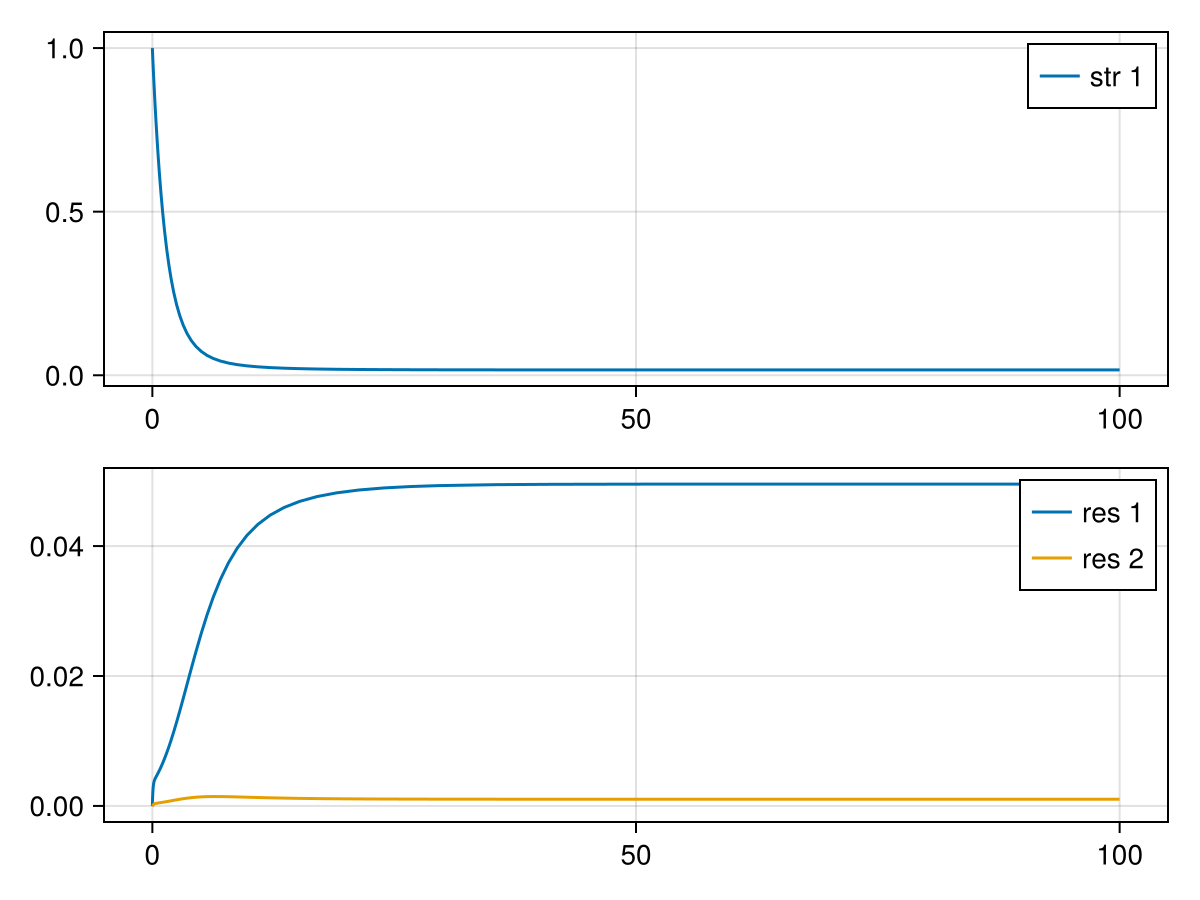

In [44]:
u0 = make_mmicrmu0_smart(mmicrm_params; u0=:onlyN)
# u0 = [10., 0., 0.]
# u0 = nssol .* (1 .+ 10. .* (rand(3) .- 0.5))
nsp = ODEProblem(mmicrmfunc!, u0, (0, 100), mmicrm_params)

check_mmicrmparams(nsp.p)
s = solve(nsp)
display(s.u[end])
plot_mmicrm_sol(s)

#### Linstab

mrl = 0.0009422859189227584


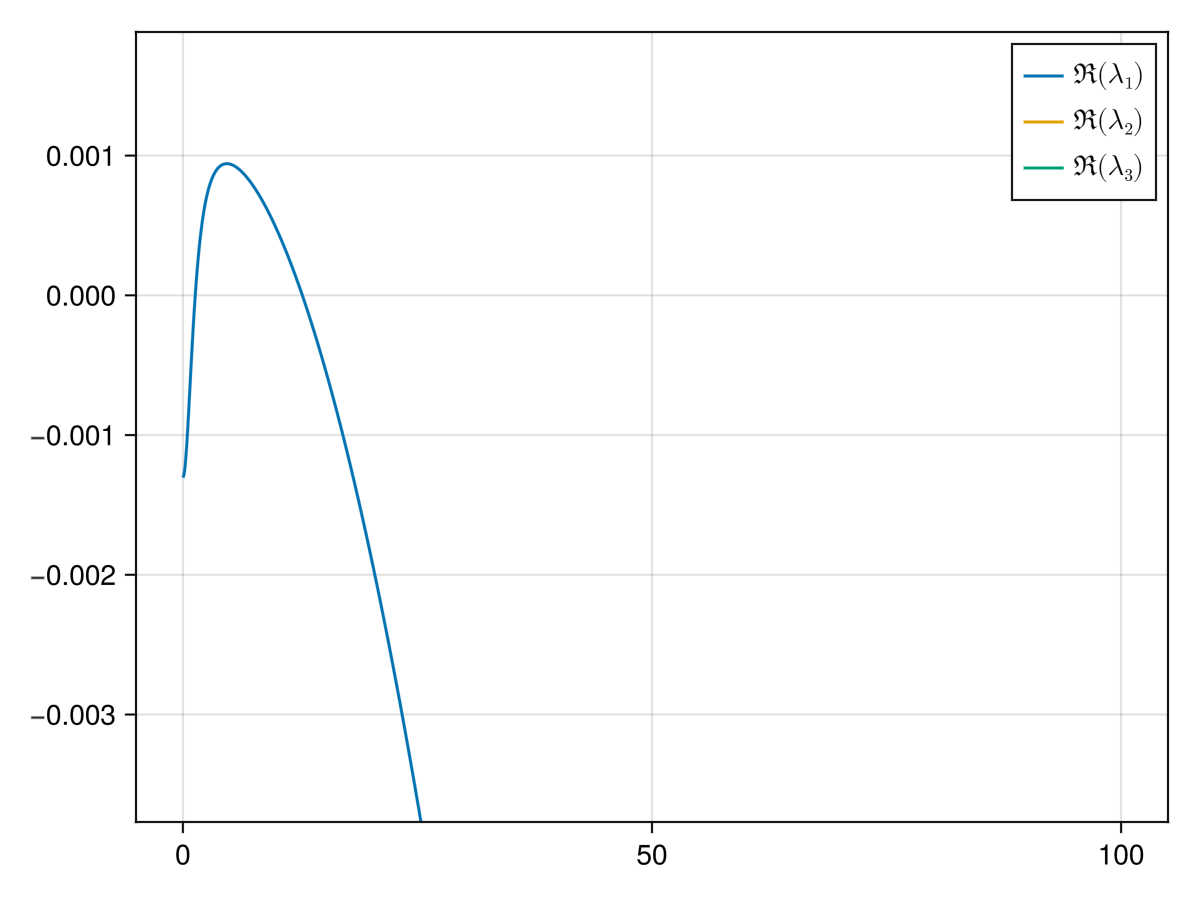

In [273]:
ks = LinRange(0.0, 100, 1000)
Ds = collect(get_Ds(mmpf))

lambdas = do_linstab_for_ks(ks, mmicrm_params, Ds, nssol);
mrl = maximum(real(lambdas))
@show mrl
faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-4*abs(mrl), 2*abs(mrl)))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [46]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(mmicrm_params, nssol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.9987892464334153
  3.0666706787900966e-5
 -0.04919390479036403

### 1D PDE sim

In [146]:
ssize = (20000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform_prop(get_Ns(mmicrm_params)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.001, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1e6, mmicrm_params, get_Ds(mmpf), space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 20000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.001]))

In [147]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  8.191191 seconds (856.75 k allocations: 5.342 GiB, 14.93% gc time)
Success
nf is 718
solution has 163 saved states
max resid is 1.35507e-06


┌ Warning: reaching negative values, minimum is -4.41538e-07
└ @ SSMCMain.ModifiedMiCRM.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/SpaceMMiCRM/smmicrm_util.jl:10


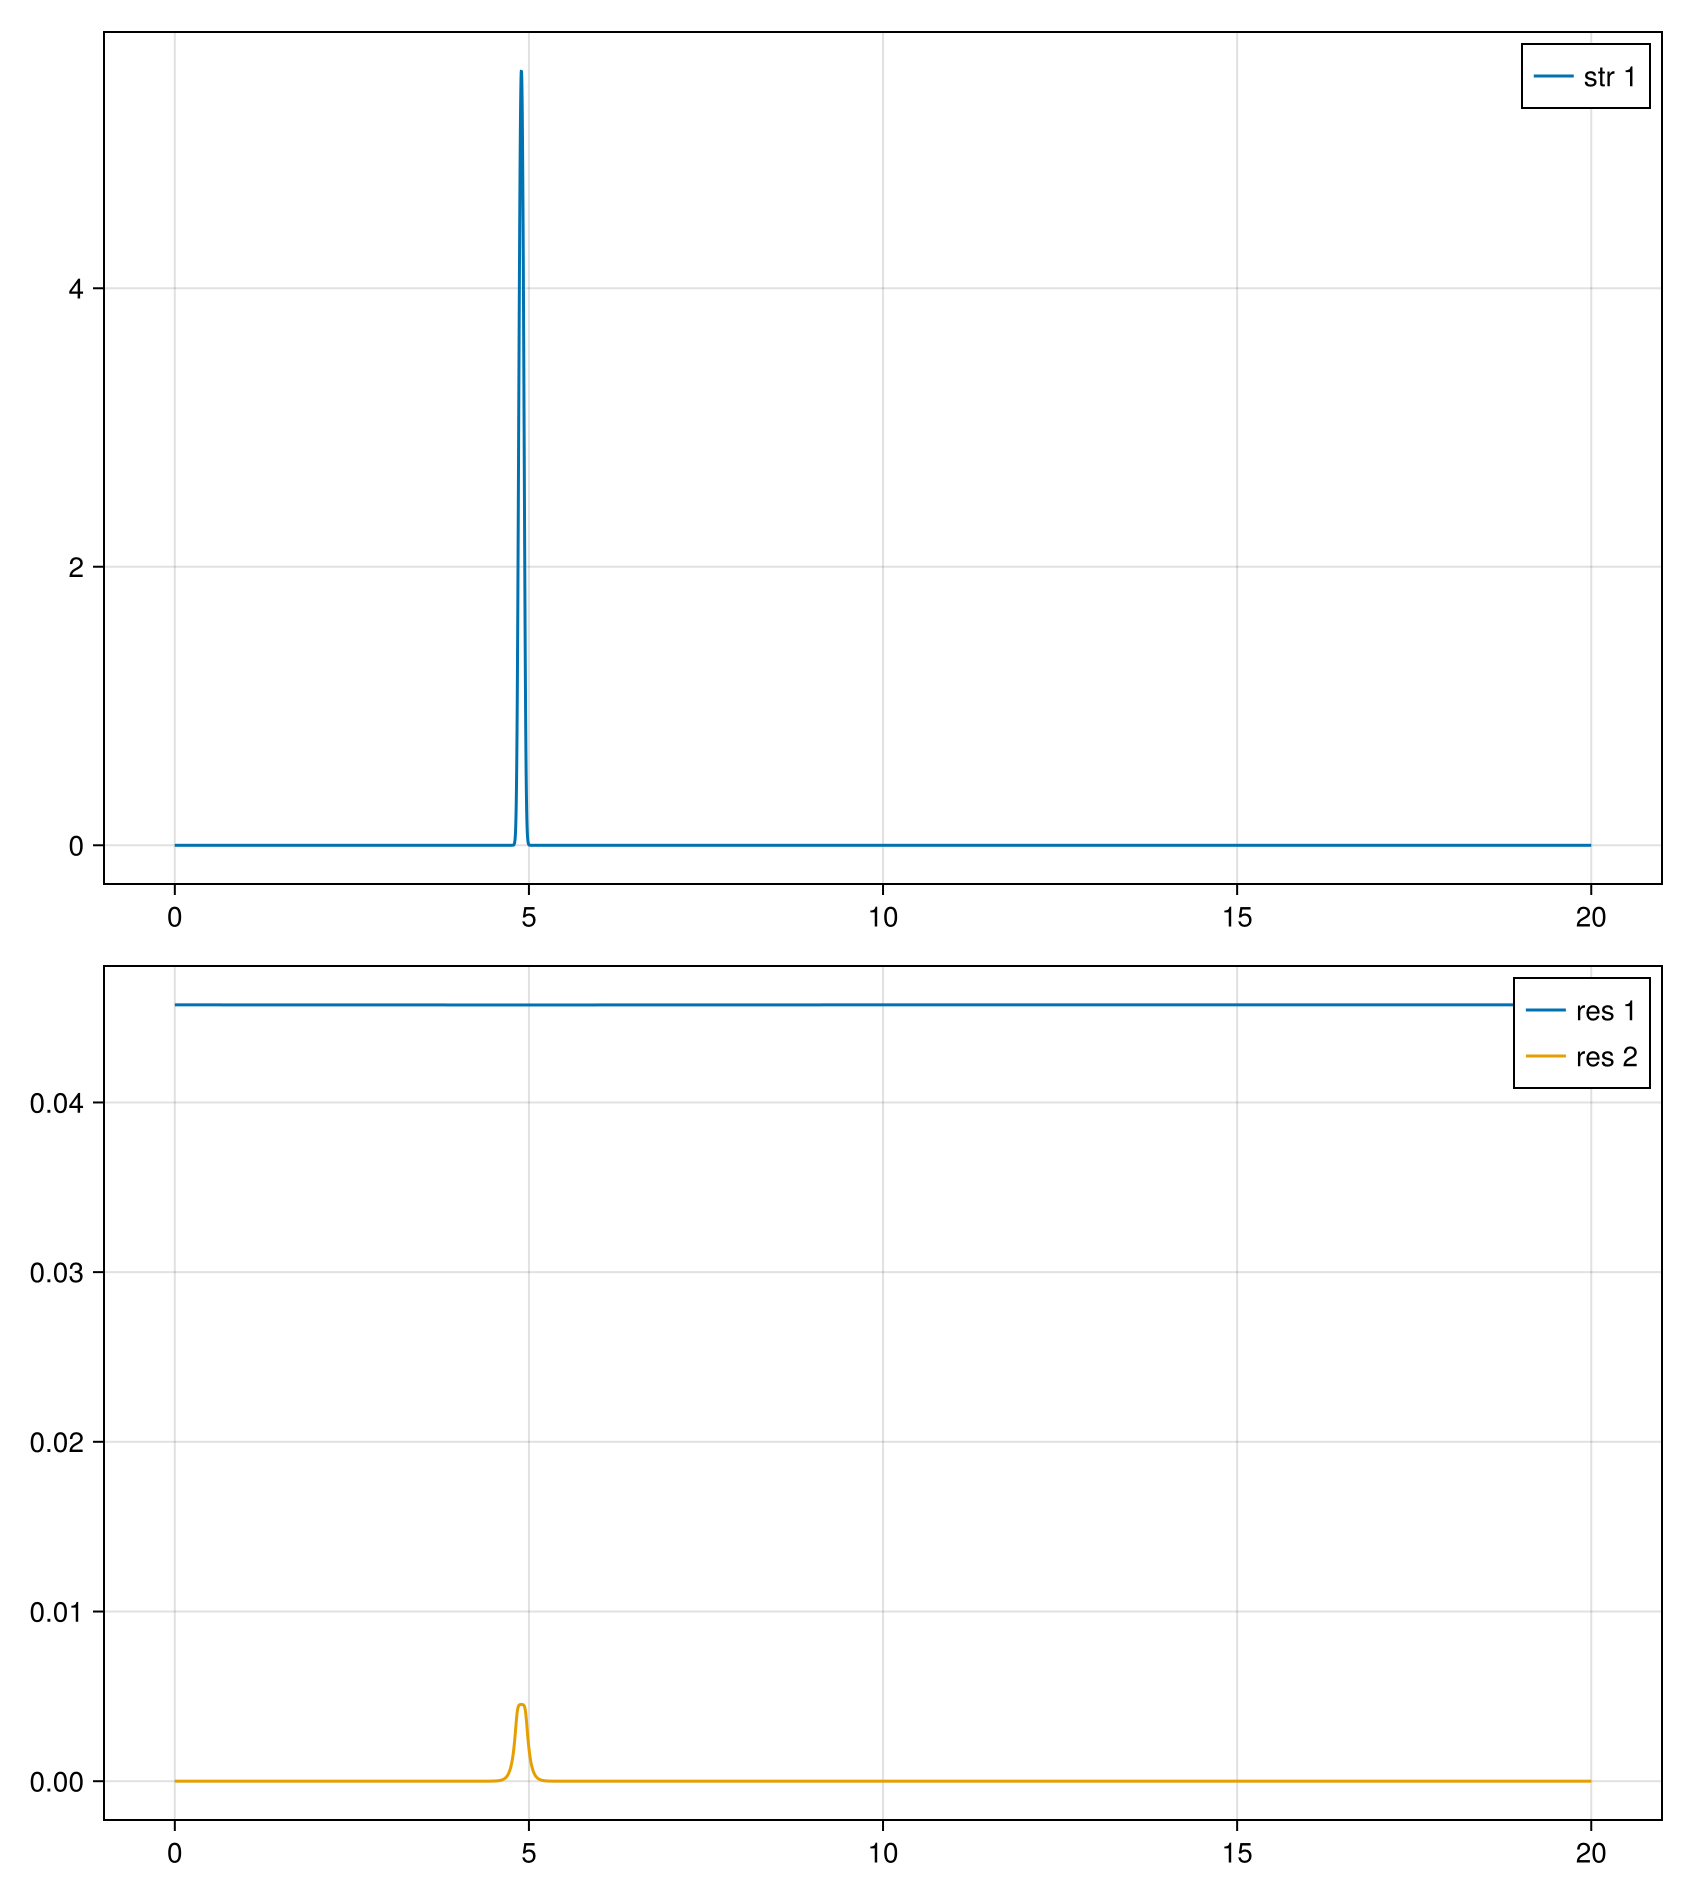

In [150]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))
display(GLMakie.Screen(), faa.figure)
faa

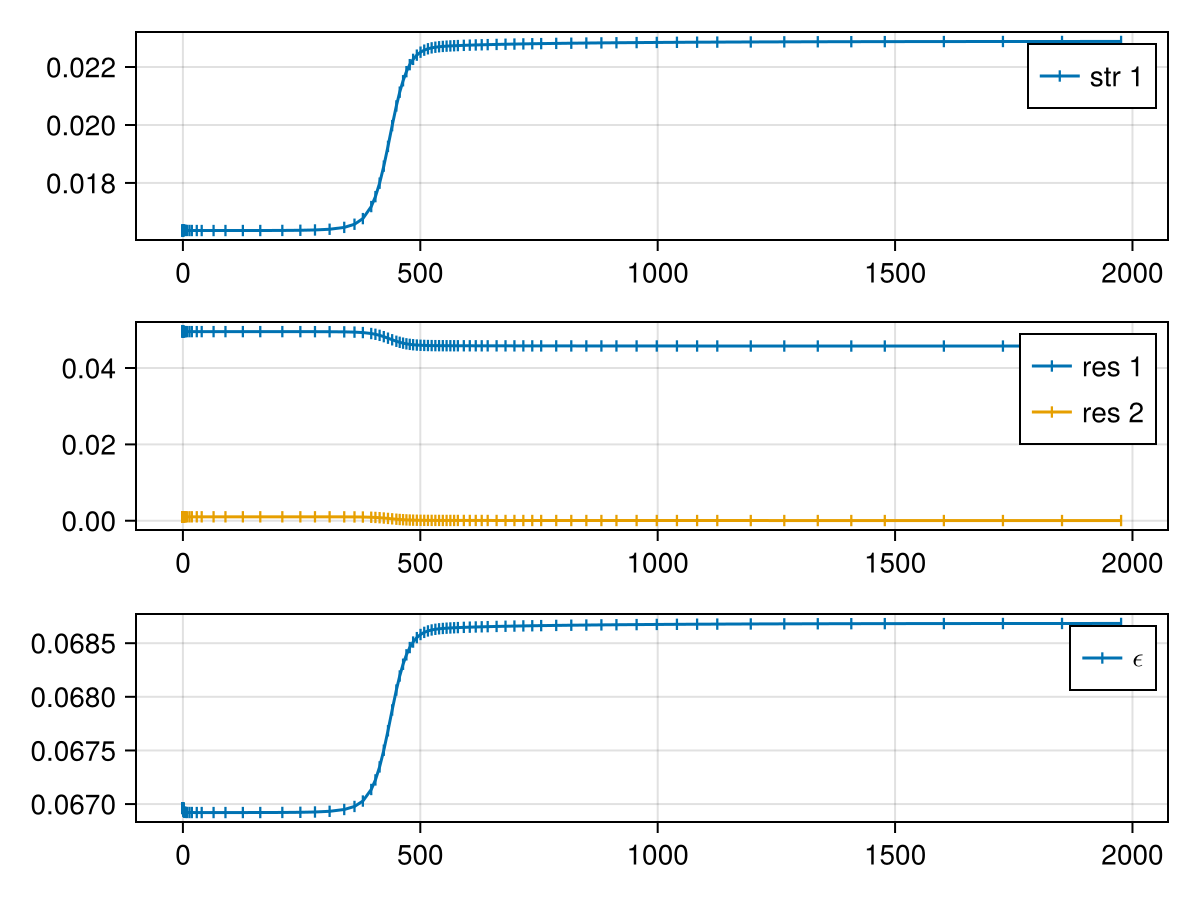

In [149]:
f = plot_smmicrm_sol_avgs(sps, 1:(length(sps.t)-10); plote=true)
# display(GLMakie.Screen(), f)